In [1]:
import os
import boto3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sagemaker.session import Session

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AffinityPropagation, KMeans, AgglomerativeClustering

In [3]:
from sklearn.decomposition import LatentDirichletAllocation

## Helper Functions & Classes

In [4]:
# small class for holding "special" print flags
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Interact with System Environment

In [5]:
# initiate s3 bucket and corresponding data folder
bucket = "ran-s3-systemic-risk"
data_folder ="Output/BalanceSheet/"

# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# discover all of the pdfs that you want to parse
paths = np.array(session.list_s3_files(bucket, data_folder))

## Line Item Label Clustering
**Using KMeans clustering for determing word similitaries amongst balance sheet items**

In [6]:
def word_matching(array: np.array, vectorizer_class, cluster_class) -> tuple:
    
    # Convert a collection of text documents to a matrix of token counts
    vectorizer = vectorizer_class
    print('Using the {} text vectorizer\n'.format(type(vectorizer_class).__name__))
    
    # produces a sparse representation of the counts using scipy.sparse.csr_matrix.
    X = vectorizer.fit_transform(array)
    
    # initialize the clustering model on words
    model = cluster_class
    
    model.fit(X)  # fit clustering model to array of strings

    # returns dataframe, mapping cluster labels to line items
    outDF = pd.DataFrame({'Labels': model.labels_, 'LineItems': array})
    
    print('\n{} clusters were found using {} algorithm'.format(model.labels_.max()+1, type(cluster_class).__name__))
    
    return model.labels_, model.cluster_centers_, outDF 

In [7]:
# reading cleaned unstructured data sets for samples 
assets = pd.read_csv('/home/ec2-user/SageMaker/SEC_X17A5/output/unstructured_assets.csv')
liability = pd.read_csv('/home/ec2-user/SageMaker/SEC_X17A5/output/unstructured_liable.csv')

**The following clustering model specifications are outlined below:**

- **array:** We select the columns from either asset or liability tables, not including CIK or Year components.
- **vectorizer_class:** We implement a standard TfidVectorizer class, converting the collection of strings to a matrix of TF-IDF features.

- **cluster_class:** We fit a KMeans clustering algorithm, employing **35 cluster** using the the classic **expectation–maximization algorithm (full)** for computing the KMeans clusters with **25 centroid seeds** to check against. We also control the random state and provided verbosity to model fits

In [8]:
clusters = 35
text_vectorizer = TfidfVectorizer(lowercase=True)
cluster_mdl = KMeans(n_clusters=clusters, n_init=25, verbose=1, random_state=1, algorithm='full')

In [9]:
# perform clustering on the asset line items
assetTerms = assets.columns.values[2:]
np.random.shuffle(assetTerms)

# divide asset terms into in and out of sample categories
insAssets = assetTerms[:-50]
outAssets = assetTerms[-50:]
assetlabel, assetCenters, df1 = word_matching(array = insAssets, 
                                              vectorizer_class = text_vectorizer, 
                                              cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration 0, inertia 1127.080360552831.
Iteration 1, inertia 674.7914043695858.
Iteration 2, inertia 661.9541442329879.
Iteration 3, inertia 659.641898047313.
Iteration 4, inertia 659.1575702457532.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 1129.5994976271602.
Iteration 1, inertia 675.5446187950049.
Iteration 2, inertia 664.4859571913424.
Iteration 3, inertia 656.4951853345868.
Iteration 4, inertia 655.1947238506448.
Iteration 5, inertia 654.5236112247748.
Iteration 6, inertia 654.390757494102.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 1166.76929350343.
Iteration 1, inertia 680.8092802342865.
Iteration 2, inertia 670.8084664721057.
Iteration 3, inertia 666.6915388919879.
Iteration 4, inertia 665.7080185447849.
Iteration 5, inertia 665.4893475358552.
Iteration 6, inertia 665.276110406363.
Converged at iteration 6: strict con

Initialization complete
Iteration 0, inertia 1145.5637265717264.
Iteration 1, inertia 690.3133565357911.
Iteration 2, inertia 678.9817848996692.
Iteration 3, inertia 675.5028854148327.
Iteration 4, inertia 674.4935008322556.
Iteration 5, inertia 674.0088872982111.
Iteration 6, inertia 673.8506201894018.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 1146.0968533716846.
Iteration 1, inertia 681.3906419143105.
Iteration 2, inertia 670.258934819733.
Iteration 3, inertia 667.0103212887637.
Iteration 4, inertia 665.7266279329336.
Iteration 5, inertia 665.5654884408384.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 1178.878214114284.
Iteration 1, inertia 688.4085404112975.
Iteration 2, inertia 676.69245967095.
Iteration 3, inertia 670.231277023903.
Iteration 4, inertia 668.3528851694401.
Iteration 5, inertia 668.0457661517266.
Iteration 6, inertia 668.0137572598647.
Iteration 7, inertia 667.9198466441597

In [10]:
# perform clustering on the liability & equity line items
liabilityTerms = liability.columns.values[2:]
np.random.shuffle(liabilityTerms)

# divide liability terms into in and out of sample categories
insLiability = liabilityTerms[:-50]
outLiability = liabilityTerms[-50:]

liabilitylabel, liabilityCenters, df2 = word_matching(array = insLiability, 
                                                      vectorizer_class = text_vectorizer, 
                                                      cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration 0, inertia 589.9704668505077.
Iteration 1, inertia 375.1022908887482.
Iteration 2, inertia 367.01696686343166.
Iteration 3, inertia 360.58049180365924.
Iteration 4, inertia 356.4578467713596.
Iteration 5, inertia 354.8993748564564.
Iteration 6, inertia 354.0144985193058.
Iteration 7, inertia 353.207503748013.
Iteration 8, inertia 352.55218080584547.
Iteration 9, inertia 352.28087161308.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 601.6912172873278.
Iteration 1, inertia 361.8733969152415.
Iteration 2, inertia 353.1476700124168.
Iteration 3, inertia 350.77348845950945.
Iteration 4, inertia 350.2667057439729.
Iteration 5, inertia 349.9306161240771.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 562.6898287042925.
Iteration 1, inertia 353.28363937038887.
Iteration 2, inertia 347.0707316856741.
Iteration 3, inertia 346.396307

Initialization complete
Iteration 0, inertia 558.153299052691.
Iteration 1, inertia 355.14575016666174.
Iteration 2, inertia 348.8970320321148.
Iteration 3, inertia 346.8087301755786.
Iteration 4, inertia 345.9360357546958.
Iteration 5, inertia 345.0435559644782.
Iteration 6, inertia 343.9545764372132.
Iteration 7, inertia 342.7994066254777.
Iteration 8, inertia 342.61031122339296.
Iteration 9, inertia 342.47903615593606.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 579.2071239314248.
Iteration 1, inertia 358.83841461827245.
Iteration 2, inertia 354.0551198351164.
Iteration 3, inertia 352.0572553367234.
Iteration 4, inertia 350.9839600153879.
Iteration 5, inertia 350.1942214770072.
Iteration 6, inertia 350.06088220775547.
Iteration 7, inertia 349.9828684165662.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 606.0977412550947.
Iteration 1, inertia 360.6889915970744.
Iteration 2, inertia 356.8396326

### Examination of Clusters Realiablity
**Observing the distance between cluster centroids, tracking numerical difference relative to other labels**

In [11]:
def distance_matrix(centers: np.ndarray):
    clusters, nfeatures  = centers.shape
    itRange = np.arange(clusters)
    
    # similar to covariance matrix, initialize memory for distance matrix
    dMat = np.zeros((clusters, clusters))
    
    for i in itRange:
        for j in itRange:
            # computing the distance between centroids to examine label closeness
            distance = np.sqrt(np.sum(np.square(centers[i, :] - centers[j, :])))
            
            # assign values to the corresponding distance matrix
            dMat[i, j] = distance
    
    return dMat

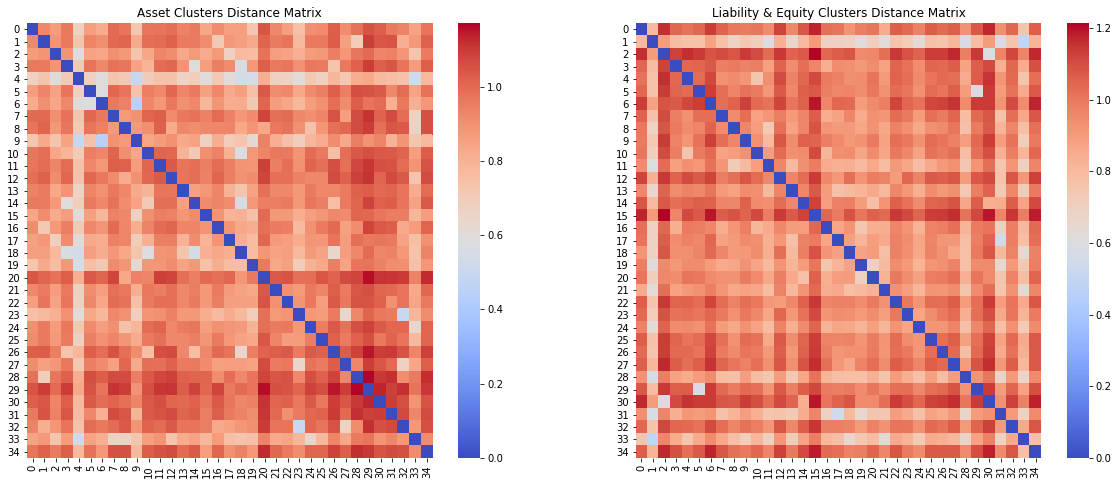

In [12]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
sns.heatmap(distance_matrix(assetCenters), cmap='coolwarm', ax=axes[0])
sns.heatmap(distance_matrix(liabilityCenters), cmap='coolwarm', ax=axes[1])
axes[0].set_title('Asset Clusters Distance Matrix')
axes[1].set_title('Liability & Equity Clusters Distance Matrix')
plt.show()

Clustering works to great effect with the vast majority of cases presented, but there still appears to be issues that persist when trying to divide the current dataset - namely more nuanced differences such as "Total Liabilites and Equity" and "Total Equity". I want to try grouping these and then clustering them again.

As exhbited, repeated clustering on a smaller subset of line items does not break it into expected groups. Rather, we arrive at similar breaks that we saw before when using a smaller KMeans cluster set. Hence, I will pursue the LDA as is, and see the label identificaition that follows.

## Latent Dirichlet Allocation with online variational Bayes algorithm
**A Topic Model for root-word detection from a list of similar strings** 

Our goal here is to determine whether using LDA decomposition is useful in determining label names for clustering classes

* The corpus is a collection of **D** documents, which will be a cluster with corresponding word groupings from KMeans
* A document is a sequence of **N** words, which corresponds to the sequence of characters of each word in the cluster
* There are **K** topics in the corpus, which will be one as we are looking to determine roots

In [13]:
def label_LDA(names, LDA_model):
    assert type(LDA_model).__name__ is 'LatentDirichletAllocation', 'Model restriction, only imposed LDA'
    
    print('Clustered names provided are:\n\n', names, '\n')
    labelNames = []
    
    # vectorize the text (string) data to be used by Latent Dirichlet Allocation algorithm
    text_mdl = TfidfVectorizer()
    vec_text = text_mdl.fit_transform(names)
    
    # feature names extracted from the TfidVectorizer
    feature_names = text_mdl.get_feature_names()
  
    # fit Laten Dirichlet Allocation model 
    mdl = LDA_model
    mdl.fit(vec_text)
    
    print()
    # print out label names determined from LDA
    for topic in mdl.components_:
        message = "Topic determined: "
        message += " ".join([feature_names[i]
                             # select the 5 most important feature names from largest to smallest order
                             for i in topic.argsort()[:-5 - 1:-1]])
        print(color.BOLD, message, color.END)
        labelNames.append(message)
    print()
    
    return labelNames

Continuing this current assesment of topic detection, we extend this to the entire subset of items computed from the clustering algorithm employed to group each of the asset/liability line items grouped before. **(Refer to KMeans Model for details on clustering)**


In [14]:
# creating names for assest line clusters
for i in range(df1.Labels.max()+1):
    print('Label', i)
    cluster_cells = df1[df1.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Securities purchased under agreements to resell (includes $302 at fair value)'
 'Securities purchased under agreements to resell (includes securities at fair value of $37,631)'
 'Securities financing transactions: Securities purchased under agreements to resell (includes securities at fair value of $40,529,352)'
 'Securities purchased under agreements to resell (includes fair value of $12,247)'
 'Securities purchased under agreements to resell (at fair value)'
 'Securities purchased under agreements to resel, at fair value'
 'Securities purchased under agreements to resell (includes $1,113 at fair value)'
 'Securities borrowed or purchased under agreements to resell (including $93,975 at fair value)'
 'Securities borrowed or purchased under agreements to resell (including $102,691 at fair value)'
 'Securities pledged under collateral agreements (Note 4)'
 'Securities purchased under agreements to resell (includes $31,580 at fair value)'
 'Secu

iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: and securities deferred of tax 


Label 5

Clustered names provided are:

 ['Securities received as collateral, at fair value (includes $30,574 pledged as collateral)'
 'Securities received as collateral, at fair value (includes $38 pledged as collateral)'
 'Other assets (includes $204 of securities received as collateral at fair value)'
 'Securities received as collateral, at fair value ($3,960 of which was encumbered)'
 'Securities received as collateral, at fair value (approximately $14,956 were pledged to various parties)'
 'Other assets (includes $6 of securities received as collateral at fair value)'
 'Securities received as collateral (includes $15,104 pledged as collateral)'
 'Securities received as collateral (includes $15,546 pledged as collateral)'
 'Securities received as collateral

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: securities value owned at fair 


Label 10

Clustered names provided are:

 ['Fixed assets (net of accumulated depreciation and amortization of $ 16,855)'
 'Fixed assets (net of accumulated depreciation of $19,375)'
 'Fixed assets (net of accumulated depreciation of $1,067)'
 'Fixed assets, at cost, (net of accumulated depreciation and amortization of $33,661)'
 'Fixed assets, at cost (net of accumulated depreciation and amortization of $46,814)'
 'Fixed assets, at cost (net of accumulated depreciation and amortization of $23,467)'
 'Fixed assets (net of accumulated depreciation of $16,034)'
 'Fixed assets (net of accumulated depreciation of $345)'
 'Fixed assets, net'
 'Fixed ass

iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: cost at exchange memberships value 


Label 16

Clustered names provided are:

 ['Assets Cash and cash equivalents' 'Cash and cash equivalents'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $7,862)'
 'Cash and cash equivalents (Note: 2)' 'CASH'
 'Cash, cash equivalents, and cash segregated for benefit of customers'
 'ASSETS Cash' 'Cash equivalents'
 'Cash, cash equivalents and cash segregated for benefit of customers'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $3,514,853)'
 'Cash and cash equivalents (including $9,822 related to consolidated VIEs)'
 'Cash and cash equivalents (includes cash equivalents at fair value of $49)'
 'Cash and cash equivalents (includes ca

iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: of customers doubtful for accounts 


Label 21

Clustered names provided are:

 ['Corporate debt.' 'Corporate debt' 'Corporate stocks'
 'Not readily marketable, at estimated fair value - Corporate and municipal debt securities'
 'Not readily marketable, at estimated fair value - Corporate debt securities'
 'Corporate stock' 'Debt instruments'
 'Corporate obligations pledged as collateral' 'Corporate'
 'Corporate debt and collateralized mortgage obligations'
 'Corporate stock (cost $586,245,565)' 'Corporate debt obligations'
 'Corporate debt (includes securities pledged as collateral of $11,378)'
 'Corporate debt securities' 'Corporate and other debt'
 'Corporate debt securities (note 3)' 'Corporate obligations'
 'Other debt securities' 'Corporate equities'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iterat

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: and resale agreements regulatory purposes 


Label 29

Clustered names provided are:

 ['Total assets' 'Total securities owned' 'TOTAL ASSETS'
 'Total financial instruments owned. at fair value' 'Total asset'
 'Total asset check'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: total assets asset owned securities 


Label 30

Clustered names provided are:

 ['Taxes receivable' 'Taxes Receivable'
 'Deferred income taves (

In [15]:
df1.to_csv('asset_LDA.csv', index=False)

In [16]:
# creating names for liability line clusters
for i in range(df2.Labels.max()+1):
    print('Label', i)
    cluster_cells = df2[df2.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Brokers, dealers and others'
 'Payable to brokers, dealers, clearing organizations, and custodians'
 'Brokers, dealers and others.'
 'Payable to brokers or dealers and clearing organizations'
 'Payable to brokers, dealers, and clearing organizations (Note 3)'
 'Payable to brokers. dealers and clearing organizations (Note 3)'
 'Payable to brokers, dealers, clearing organizations, and customers'
 'Payable to brokers, dealers and clearing organizations'
 'Payable to customers, brokers, dealers and clearing organizations'
 'Payables to brokers and clearing organizations'
 'Payable to brokers, dealers, clearing organizations and others'
 'Payable to broker-dealers, customers and clearing organizations'
 'Payable to brokers, dealers, and clearing organizations'
 'Payble to brokers. dealers and clearing organizations (Note 3)'
 'Payable to clearing organizations'
 'Brokers, dealers and other organizations'
 'Payables to brokers, dealers, clearing org

iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: other liabilities accrued expenses and 


Label 11

Clustered names provided are:

 ["MEMBER'S EQUITY" "Member's Contributions" "Member's capital"
 "Common members' interest" "Member's interest"
 'Guaranteed payments to member' 'Non controlling interest'
 'Noncontrolling interest' "Member's Equity" "Preferred member's interest"
 "Morgan Stanley & Co. LLC member's equity" 'Interest rate swap'
 'Interest rate swap (note 4)' "Member's contributions" "Member's equity"] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: member interest equity contributions rate 


Label 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: affiliates to parent payable loan 


Label 19

Clustered names provided are:

 ['Securities loaned (includes $31,698 at fair value)'
 'Securities loaned (includes $5, 149 at fair value)'
 'Securities loaned (including $240.5 million of collateral at fair value)'
 'Securities loaned (includes $998 at fair value)'
 'Securities loaned (includes $5,646 at fair value)'
 'Securities loaned (including accrued rebates)'
 'Securities loaned (includes $28,978 at fair value)'
 'Deposits received for securities loaned'
 'Securities loaned (includes $3,413 at fair value)'
 'Securities loaned (includes fair value of $1,609)'
 'Securities loaned (includes $17,569 at fair value)'
 'Securities loa

 Topic determined: accumulated earnings other comprehensive loss 


Label 25

Clustered names provided are:

 ['Capital in excess of par value' 'Paid-in capital' "Partners' capital"
 'MEMBERS CAPITAL' 'Additional Paid-in capital' "MEMBERS' CAPITAL"
 'Paid-in capital in excess of par value' "Members' capital"] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: capital members in paid partners 


Label 26

Clustered names provided are:

 ['Commitments, contingencies and guarantees Subordinated borrowings'
 'Commitments, contingencies and guarantees: Subordinated indebtedness'
 'Commitments, contingencies and guarantees: Subordinated borrowings'
 'Commitments, contingencies, and guarantees: Subordinated borrowings'
 'Commitments an

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: government and agency securities federal 


Label 33

Clustered names provided are:

 ['Payable for order flow' 'Notes payable to SSBH'
 'Asset acquisition payable' 'Bank loan payable'
 'Payable to clearing broker' 'Customer drafts payable'
 'Overdrafts payable' 'Payable to clients and counterparties'
 'Notes payable' 'Payable to clearing organization'
 'Exchange, clearance, and regulatory fees payable' 'Payable to FICC'
 'Income toxes payable (Notes 2 and 14)'
 'Payable for liquidity and order flow' 'Drafts payable'
 'Clearance and regulatory fees payable' 'Payable to counterparties'
 'Payable to banks' 'Notes payable to CGMHI' 'Payable to broker-dealers'
 'Note payable' 'Payable

In [17]:
df2.to_csv('liability_LDA.csv', index=False)